In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split
from prettytable import PrettyTable
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_auc_score,log_loss
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix
from scipy.sparse import hstack
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [ ]:
#!kaggle datasets download -d rupakroy/online-payments-fraud-detection-dataset

In [ ]:
# !unzip /content/drive/MyDrive/Kaggle/online-payments-fraud-detection-dataset.zip

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/Kaggle/Online Payments Fraud Detection/PS_20174392719_1491204439457_log.csv")

In [ ]:
df.shape

(6362620, 11)

In [ ]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [ ]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [ ]:
df["isFraud"].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [ ]:
fraud=df[df["isFraud"]==1]
nofraud=df[df["isFraud"]==0]

It's a highly imbalanced dataset

In [ ]:
df=df.drop("isFlaggedFraud",axis=1)

STEP

In [ ]:
df["step"]=df["step"]//24

Histogram for a time steps where there was no fraud

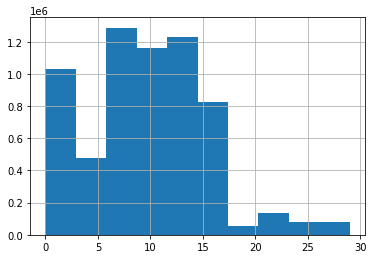

In [ ]:
df[df.iloc[:,-1]==0]["step"].hist(bins=10)

Histogram for a time steps where there was a fraud

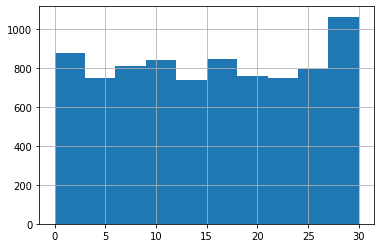

In [ ]:
df[df.iloc[:,-1]==1]["step"].hist(bins=10)

The probability that payments which took more than 15 days is significantly high. But, in real world, transactions seldom go beyond a week unless it's a not a bank transfer, international transfer and where huge amount is involved.So, let's investigate the type of transactions.


**TYPE**

In [ ]:
df["type"].value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

Now, let's investigate if there is any difference between payments of different kind.

In [ ]:
nofraud.groupby("type")["step"].describe()

,count,mean,std,min,25%,50%,75%,max
type,,,,,,,,
CASH_IN,1399284.0,244.490093,142.925962,1.0,156.0,249.0,345.0,718.0
CASH_OUT,2233384.0,240.667014,140.492174,1.0,155.0,236.0,332.0,718.0
DEBIT,41432.0,248.440481,149.843650,1.0,153.0,252.0,350.0,718.0
PAYMENT,2151495.0,244.378179,142.695066,1.0,156.0,249.0,335.0,718.0
TRANSFER,528812.0,245.708590,143.922349,1.0,156.0,249.0,346.0,718.0


In [ ]:
fraud.groupby("type")["step"].describe()

,count,mean,std,min,25%,50%,75%,max
type,,,,,,,,
CASH_OUT,4116.0,367.720360,216.670186,1.0,180.0,367.0,558.0,743.0
TRANSFER,4097.0,369.110569,216.129726,1.0,182.0,369.0,558.0,743.0


Only Cashout and Transfer type of payments have fraud issue. Also, Cashout and transfer which had been classified as fraud have taken an average time of more than 14 days.

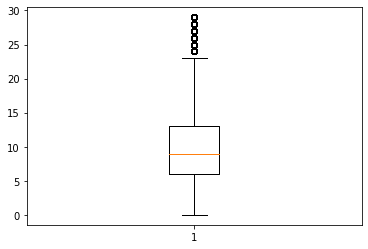

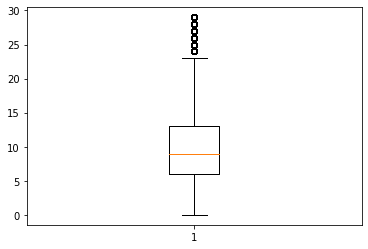

In [ ]:
plt.figure()
plt.boxplot(df.loc[np.where((df['type']=="CASH_OUT") & (df['isFraud']== 0) )]["step"])

plt.figure()
plt.boxplot(df.loc[np.where((df['type']=="CASH_OUT") & (df['isFraud']== 0) )]["step"])


plt.show()

Excluding some outliers, there is a high probability that a transaction is fraud if time taken is higher than 15 days. Let's use response coding for Type column.

**NameOrig**

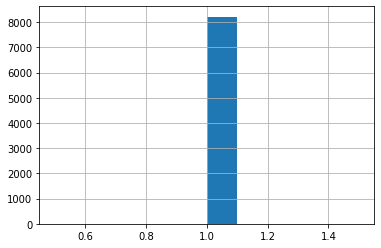

In [ ]:
fraud["nameOrig"].value_counts().hist()

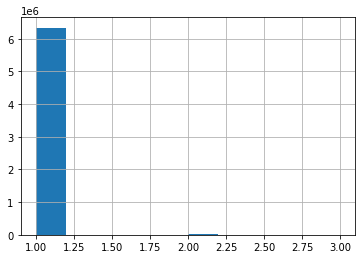

In [ ]:
nofraud["nameOrig"].value_counts().hist()

In [ ]:
d=dict(df["nameOrig"].value_counts(sort=False))

In [ ]:
df["nameOrig"]=df["nameOrig"].map(d)

In [ ]:
df["nameOrig"]

0          1
1          1
2          1
3          1
4          1
          ..
6362615    1
6362616    1
6362617    1
6362618    1
6362619    1
Name: nameOrig, Length: 6362620, dtype: int64

Failed transactions have had orginated a transaction utmost once.  let's create a feature which counts the number of times a transaction is originated.

**NameDest**

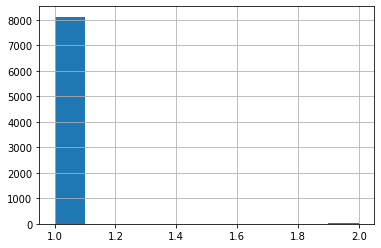

In [ ]:
fraud["nameDest"].value_counts().hist()

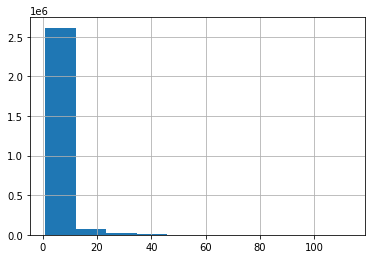

In [ ]:
nofraud["nameDest"].value_counts().hist()

Receivers had utmost two fraud transactions. let's create a feature which records whether received transactions are more than 2 or not.

In [ ]:
O=dict(df["nameDest"].value_counts(sort=False))

In [ ]:
df["nameDest"]=df["nameDest"].map(O)

In [ ]:
df.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,0,PAYMENT,9839.64,1,170136.0,160296.36,1,0.0,0.0,0
1,0,PAYMENT,1864.28,1,21249.0,19384.72,1,0.0,0.0,0
2,0,TRANSFER,181.00,1,181.0,0.00,44,0.0,0.0,1
3,0,CASH_OUT,181.00,1,181.0,0.00,41,21182.0,0.0,1
4,0,PAYMENT,11668.14,1,41554.0,29885.86,1,0.0,0.0,0


**Amount**

In [ ]:
nofraud["amount"].describe()

count    6.354407e+06
mean     1.781970e+05
std      5.962370e+05
min      1.000000e-02
25%      1.336840e+04
50%      7.468472e+04
75%      2.083648e+05
max      9.244552e+07
Name: amount, dtype: float64

In [ ]:
fraud["amount"].describe()

count    8.213000e+03
mean     1.467967e+06
std      2.404253e+06
min      0.000000e+00
25%      1.270913e+05
50%      4.414234e+05
75%      1.517771e+06
max      1.000000e+07
Name: amount, dtype: float64

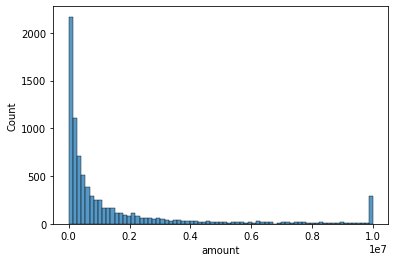

In [ ]:
sns.histplot(fraud["amount"])

(0.0, 10000000.0)

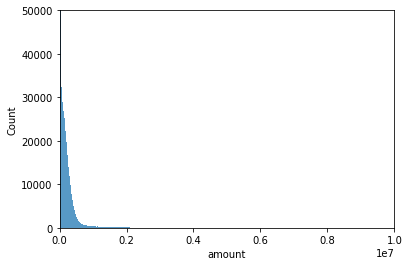

In [ ]:
sns.histplot(nofraud["amount"])
plt.ylim(0,50000)
plt.xlim(0,1e7)

Higher the amount, the higher the risk of fraud.

**oldbalanceOrg** , **newbalanceOrig**, **oldbalanceDest** and **newbalanceDest**

The follwing features can be engineered.

1. Did the sender initiate any transaction?
2. Was the amount has than the sender initially had?
3. Did the receiver get amount ?
4. Was more than expected amount or less than expected amount debited from the transaction at senders end?
5. Did the receiver get credited by more or less amount?


1. Sender balance change Check Flag

If there is a difference between the balance of originator account then it can be understood that there is an initation.

In [ ]:
x=abs(df["oldbalanceOrg"]-df["newbalanceOrig"])

In [ ]:
df["Sender_balance_change"]=abs(df["oldbalanceOrg"]-df["newbalanceOrig"]).map(lambda x:1 if -100<x<100 else 0)

In [ ]:
df[df["isFraud"]==1]["Sender_balance_change"].value_counts()

0    8154
1      59
Name: Sender_balance_change, dtype: int64

Majority of the fraud transactions have had no change in originator account balance.

2. Was more than expected amount or less than expected amount debited from the transaction at senders end?

In [ ]:
df["Expected_amount_more_or_less_deducted_from_originator"]=abs(df["oldbalanceOrg"]-df["newbalanceOrig"]).map(lambda x:1 if (-100>x or x<100) else 0)

In [ ]:
df[df["isFraud"]==1]["Expected_amount_more_or_less_deducted_from_originator"].value_counts()

0    8154
1      59
Name: Expected_amount_more_or_less_deducted_from_originator, dtype: int64

In [ ]:
df[df["isFraud"]==0]["Expected_amount_more_or_less_deducted_from_originator"].value_counts()

0    4229342
1    2125065
Name: Expected_amount_more_or_less_deducted_from_originator, dtype: int64

3. Amount vs existing balance flag

In [ ]:
df["oldbalanceOrg"]>df["amount"]

0           True
1           True
2          False
3          False
4           True
           ...  
6362615    False
6362616    False
6362617    False
6362618    False
6362619    False
Length: 6362620, dtype: bool

In [ ]:
df[df["oldbalanceOrg"]-df["amount"]==0]["isFraud"].value_counts()

1    8034
Name: isFraud, dtype: int64

If oldbalance and amount equal to zero then it is definitely a fraud. So, let's create a flag column.

In [ ]:
df["Amount_is_less_than_existing_balance"]=abs(df["oldbalanceOrg"]-df["amount"]).map(lambda x:1 if x==0 else 0)

4. Did the receiver get amount ?

In [ ]:
#Let's check whether the receiver got any amount or not
x=abs(df["oldbalanceDest"]-df["newbalanceDest"])

In [ ]:
df["receiver_balance_change"]=abs(df["oldbalanceDest"]-df["newbalanceDest"]).map(lambda x:1 if -100<x<100 else 0)

In [ ]:
df[df["isFraud"]==1]["receiver_balance_change"].value_counts()

0    4126
1    4087
Name: receiver_balance_change, dtype: int64

In [ ]:
df[df["isFraud"]==0]["receiver_balance_change"].value_counts()


0    4039159
1    2315248
Name: receiver_balance_change, dtype: int64

Receiver balance doesn't tell anything about Fraud.

5. Did the receiver get credited by more or less amount?

In [ ]:
df["Expected_amount_more_or_less"]=abs(df["oldbalanceDest"]-df["newbalanceDest"]).map(lambda x:1 if (-100>x or x<100) else 0)

In [ ]:
df[df["isFraud"]==1]["Expected_amount_more_or_less"].value_counts()

0    4126
1    4087
Name: Expected_amount_more_or_less, dtype: int64

In [ ]:
df[df["isFraud"]==0]["Expected_amount_more_or_less"].value_counts()

0    4039159
1    2315248
Name: Expected_amount_more_or_less, dtype: int64

Expected amount more or less balance doesn't tell anything about Fraud.

Let's try onehot encoding the type column and run the Logistic Regression.

In [ ]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'Sender_balance_change',
       'Expected_amount_more_or_less_deducted_from_originator',
       'Amount_is_less_than_existing_balance', 'receiver_balance_change',
       'Expected_amount_more_or_less'],
      dtype='object')

In [ ]:
Y=df["isFraud"]
X=df.drop("isFraud",axis=1)

In [ ]:
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

Encoding using one hot encoding

In [ ]:

ohe = OneHotEncoder(sparse=False)
ohe.fit(train_df[['type']])

def get_ohe(df):
    temp_df = pd.DataFrame(data=ohe.transform(df[['type']]), columns=ohe.get_feature_names_out())
    df.drop(columns=['type'], axis=1, inplace=True)
    df = pd.concat([df.reset_index(drop=True), temp_df], axis=1)
    return df

train_df = get_ohe(train_df)
test_df = get_ohe(test_df)
cv_df=get_ohe(cv_df)

Response Coding

Logistic Regression

for alpha = 0.001
Log Loss : 0.00987661181154432
for alpha = 0.01
Log Loss : 0.00987661181154432
for alpha = 0.1
Log Loss : 0.00987661181154432
for alpha = 1
Log Loss : 0.00987661181154432
for alpha = 10
Log Loss : 0.00987661181154432
for alpha = 100
Log Loss : 0.00924367309030548
for alpha = 1000
Log Loss : 0.008843047053898597
for alpha = 10000
Log Loss : 0.009100530223828172


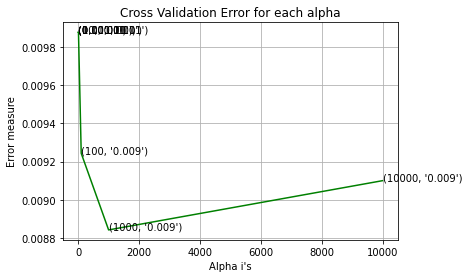

For values of best alpha =  1000 The train log loss is: 0.008678056104452605
For values of best alpha =  1000 The cross validation log loss is: 0.008843047053898597
For values of best alpha =  1000 The test log loss is: 0.00879488048828656


In [ ]:
alpha = [10 ** x for x in range(-3, 5)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier( alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_df, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_df, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_df)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_cv, sig_clf_probs))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier( alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_df, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_df, y_train)

predict_y = sig_clf.predict_proba(train_df)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_df)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_df)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

In [ ]:
predict_y=sig_clf.predict(test_df)

In [ ]:
predict_y

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
confusion_matrix(predict_y,y_test)

array([[1270881,    1643],
       [      0,       0]])

This LR model is classifying zero fraud case correctly. So, there this model is performing worse than a dumb model which can be designed to produce 0(NoFraud).

Random Forest

In [ ]:
alpha = [100,200,500]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_df, y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_df, y_train)
        sig_clf_probs = sig_clf.predict_proba(cv_df)
        cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(y_cv, sig_clf_probs))

fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/2)],max_depth[int(i%2)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


#best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_df, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_df, y_train)

predict_y = sig_clf.predict_proba(train_df)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_df)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_df)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 5.475487344846203e-05
for n_estimators = 100 and max depth =  10
Log Loss : 5.428982763864615e-05
for n_estimators = 200 and max depth =  5
Log Loss : 5.469786186327161e-05
for n_estimators = 200 and max depth =  10
Log Loss : 5.4282755392891454e-05
for n_estimators = 500 and max depth =  5
Log Loss : 5.4732438668095125e-05
for n_estimators = 500 and max depth =  10
Log Loss : 5.4306159518457334e-05
for n_estimators = 1000 and max depth =  5


KeyboardInterrupt: ignored

In [ ]:
clf = RandomForestClassifier(n_estimators=250, criterion='gini', max_depth=5, random_state=42, n_jobs=-1)
clf.fit(train_df, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_df, y_train)

predict_y = sig_clf.predict_proba(train_df)
print('For values of best estimator = ', 250, "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_df)
print('For values of best estimator = ', 250, "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_df)
print('For values of best estimator = ', 250, "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best estimator =  250 The train log loss is: 4.21168858664559e-05
For values of best estimator =  250 The cross validation log loss is: 0.00011470200633220393
For values of best estimator =  250 The test log loss is: 0.00010260650966168804


The differences between errors is minimal and almost negligible. So, the model is doing pretty well. Now, let's look at the confusion matrix.

In [ ]:
predict_y=sig_clf.predict(test_df)

In [ ]:
confusion_matrix(predict_y,y_test)

array([[1270881,      10],
       [      0,    1633]])

The model is doing a terrific job at classification. Let's look at it's ROC-AUC score now.

In [ ]:
roc_auc_score(y_test, predict_y)

0.996956786366403

The ROC-AUC score is pretty decent too

In [ ]:
f1_score(y_test, predict_y, average='micro')

0.9999921416020444

F1-score is pretty decent too.

In [ ]:
recall_score(y_test, predict_y, average='micro')

0.9999921416020444

In [ ]:
precision_score(y_test, predict_y, average='micro')

0.9999921416020444

Recall and Precision are equal. So,our algorithm has almost classified equal number of classes as positive and negative.

In [ ]:
abs(len(y_test[y_test==1])-len(predict_y[predict_y==1]))

10

Only 10 Fraud cases have been classified as not fraud cases.